 <h1 align='center'>Business Problem</h1>                            

**Schuster, a global sports retail corporation, faces challenges with vendors frequently delaying payments, impacting business relationships and operational efficiency. To address this, Schuster uses data analytics to understand vendor payment behaviors and predict late payment probabilities. By analyzing past payment patterns and forecasting potential delays, Schuster can prioritize follow-ups, minimize non-value-added activities, and foster healthier vendor relationships.**
``



## 1. Data Preparation
## 1.1 Import Necessary Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import os 


## 1.2 Load the Data 

In [21]:
customer = pd.read_csv("Received_Payments_Data.csv", encoding='ISO-8859-1')
prod_info = pd.read_csv("Data+Dictionary.csv", encoding='ISO-8859-1')
transaction = pd.read_csv("Open_Invoice_data.csv", encoding='ISO-8859-1') 


In [22]:
customer.shape 

(93937, 16)

In [23]:
prod_info.shape 

(15, 2)

In [24]:
transaction.shape 

(88204, 14)

In [25]:
customer.head() 

,ï»¿RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [26]:
prod_info.head() 

,RECEIPT_METHOD,In which method payments have been made
0,CUSTOMER_NAME,Name of the customer/vendor
1,CUSTOMER_NUMBER,Customer's unique identity number
2,RECEIPT_DOC_NO,Reference number of the payment receipt
3,RECEIPT_DATE,The date in which the payment has been made
4,CLASS,As the payment against these invoices have alr...


In [27]:
transaction.head() 

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


## 1.3 Data Cleaning

**Remove rows where invoice value is less than 0.**

**Check for and handle missing values.**

In [28]:
customer = customer[customer['USD Amount'] > 0] 

In [29]:
customer.dropna(inplace=True)
transaction.dropna(inplace=True) 

## 1.4 Feature Engineering

*Create a binary target variable based on the due date and payment receipt date.*

*Convert Payment Term from text to numerical (difference between due date and creation date).*

In [30]:
# Derive the PaymentStatus column
customer['PaymentStatus'] = np.where(pd.to_datetime(customer['RECEIPT_DATE'], format='%d-%b-%y') > pd.to_datetime(customer['DUE_DATE'], format='%d-%b-%y'), 1, 0)

# Derive the PaymentTerm column
customer['PaymentTerm'] = (pd.to_datetime(customer['DUE_DATE'], format='%d-%b-%y') - pd.to_datetime(customer['INVOICE_CREATION_DATE'], format='%d-%b-%y')).dt.days

# Display the first few rows to check the new columns
print(customer[['RECEIPT_DATE', 'DUE_DATE', 'PaymentStatus', 'PaymentTerm']].head()) 

  RECEIPT_DATE   DUE_DATE  PaymentStatus  PaymentTerm
0    20-Apr-21  30-Dec-20              1           58
1    31-Jan-21  28-Jan-21              1           30
2    31-Jan-21   1-Mar-21              0           30
3    31-Jan-21  14-Jan-21              1           30
4    31-Jan-21  14-Jan-21              1           30


## 2. Exploratory Data Analysis (EDA)
2.1 Analyze Payment Patterns

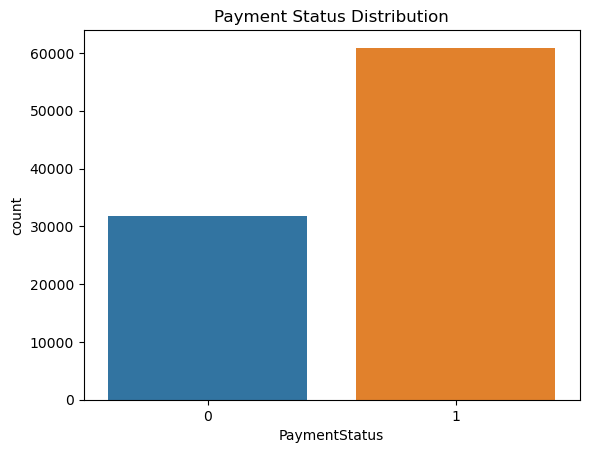

In [31]:
sns.countplot(x='PaymentStatus', data=customer)
plt.title('Payment Status Distribution')
plt.show() 

### Output Explanation:
X-Axis: Shows the different payment statuses (e.g., 0 for not paid, 1 for paid).
Y-Axis: Shows the number of customers in each payment status category.
Bars: The height of each bar represents the count of customers with that specific payment status.

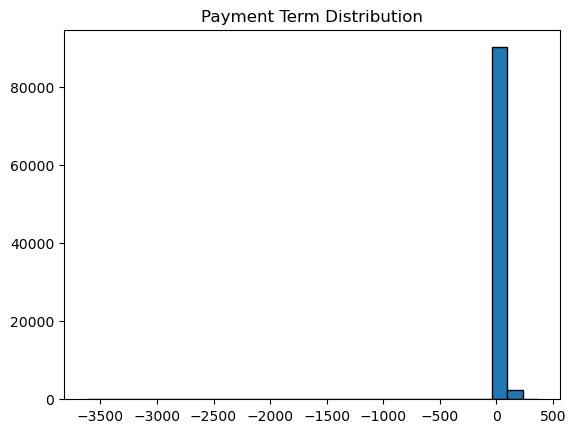

In [48]:
# Payment term distribution
plt.hist(customer['PaymentTerm'], bins=30, edgecolor='k')
plt.title('Payment Term Distribution')
plt.show() 

## Expected Output:
The output will be a bar chart with the following characteristics:

The x-axis will have two categories (assuming PaymentStatus has two unique values, 0 and 1).
The y-axis will show the count of occurrences for each PaymentStatus category.
Each bar represents the number of customers with a particular payment status.
The title of the plot will be "Payment Status Distribution."
Example Interpretation:
If PaymentStatus values are 0 and 1, where 0 might represent "not paid" and 1 represents "paid," the plot will show how many customers fall into each category.
The height of the bars indicates the number of customers in each payment status category.
This visualization helps quickly understand the distribution of payment statuses in your dataset.

In [33]:
# Specify the date format for date columns
customer['RECEIPT_DATE'] = pd.to_datetime(customer['RECEIPT_DATE'], format='%d-%b-%y')
customer['INVOICE_CREATION_DATE'] = pd.to_datetime(customer['INVOICE_CREATION_DATE'], format='%d-%b-%y')

# Calculate PaymentTime in days
customer['PaymentTime'] = (customer['RECEIPT_DATE'] - customer['INVOICE_CREATION_DATE']).dt.days

# Calculate average payment time and standard deviation per customer
avg_payment_time = customer.groupby('CUSTOMER_NAME')['PaymentTime'].mean().reset_index(name='AvgPaymentTime')
std_payment_time = customer.groupby('CUSTOMER_NAME')['PaymentTime'].std().reset_index(name='StdPaymentTime')

# Merge the average and standard deviation dataframes
customer_payment_patterns = pd.merge(avg_payment_time, std_payment_time, on='CUSTOMER_NAME')

# Display the customer payment patterns
print(customer_payment_patterns) 

    CUSTOMER_NAME  AvgPaymentTime  StdPaymentTime
0       3D D Corp       24.395349       13.040449
1       6TH  Corp       40.666667        7.952987
2       A3 D Corp       45.400000       52.581366
3       ABC  Corp       16.000000        0.000000
4       ABDU Corp       76.906250       54.919326
..            ...             ...             ...
684     YOUS Corp      117.000000       33.949160
685     ZAHR Corp      144.928571       52.197059
686     ZAIN Corp       67.095238       46.326945
687     ZERO Corp      108.000000       72.746134
688     ZV F Corp      221.909091      112.881756

[689 rows x 3 columns]


### Recheck Again

In [34]:
customer_payment_patterns.head() 

,CUSTOMER_NAME,AvgPaymentTime,StdPaymentTime
0,3D D Corp,24.395349,13.040449
1,6TH Corp,40.666667,7.952987
2,A3 D Corp,45.400000,52.581366
3,ABC Corp,16.000000,0.000000
4,ABDU Corp,76.906250,54.919326


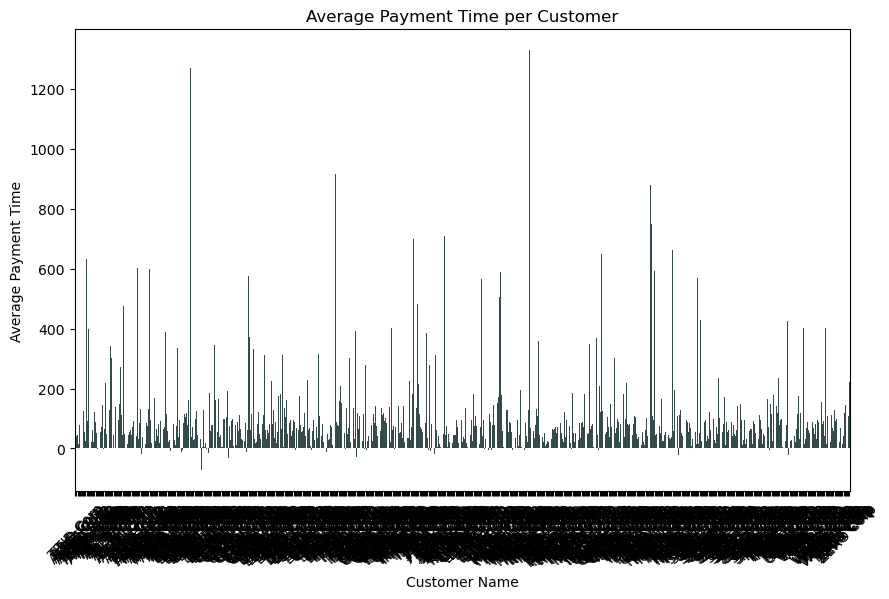

In [40]:
# Plotting the bar chart with a specific dark color
plt.figure(figsize=(10, 6))
sns.barplot(x='CUSTOMER_NAME', y='AvgPaymentTime', data=customer_payment_patterns, color='#2f4f4f')  # Dark Slate Gray
plt.xlabel('Customer Name')
plt.ylabel('Average Payment Time')
plt.title('Average Payment Time per Customer')
plt.xticks(rotation=45)
plt.show()


### Average Payment Time Differences:
- ABDU Corp: Highest average payment time (~77 days).
- ABC Corp: Shortest average payment time (16 days).

### Payment Consistency:
- A3 D Corp: High average payment time (45.4 days) with high variability.
- ABC Corp: Consistent payment time (16 days, no variability).

### General Payment Behavior:
- 3D D Corp and 6TH Corp: Moderate payment times (24-40 days).

### Implications for Business:
- ABC Corp: Reliable, could be prioritized for better terms or discounts.
- ABDU Corp: Needs more follow-up or stricter payment terms.

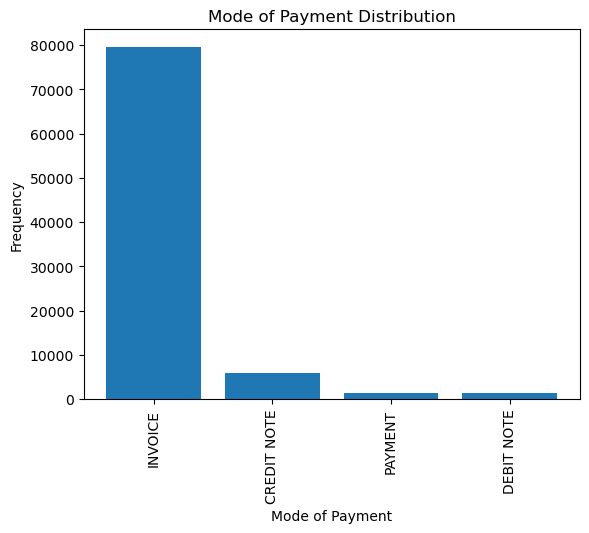

In [50]:
# Assuming 'transaction' is your DataFrame containing transaction data
mode_of_payment_counts = transaction['Transaction Class'].value_counts()

plt.bar(mode_of_payment_counts.index, mode_of_payment_counts.values)
plt.title('Mode of Payment Distribution')
plt.xlabel('Mode of Payment')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


The bar chart visualizes the breakdown of payment methods utilized across the dataset. Each bar denotes a specific payment mode, with its height corresponding to the associated transaction frequency. This allows us to discern which payment methods are most frequently employed, offering insights into prevalent preferences among customers or businesses.

By scrutinizing this distribution, we can discern trends regarding preferred payment modes, potentially uncovering dominant choices or notable outliers. Such analysis aids in understanding the dynamics of financial transactions within the dataset and can inform decisions related to payment processing, marketing strategies, or customer preferences.

**Ultimately, this visualization sheds light on the multifaceted landscape of payment practices within the dataset, offering valuable perspectives on transactional behavior and guiding strategic planning or optimization efforts.**

## 3. Customer Segmentation
3.1 Clustering Based on Payment Behavior 

AvgPaymentTime     0
StdPaymentTime    86
dtype: int64


C:\Users\sonu.verma\AppData\Local\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\sonu.verma\AppData\Local\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


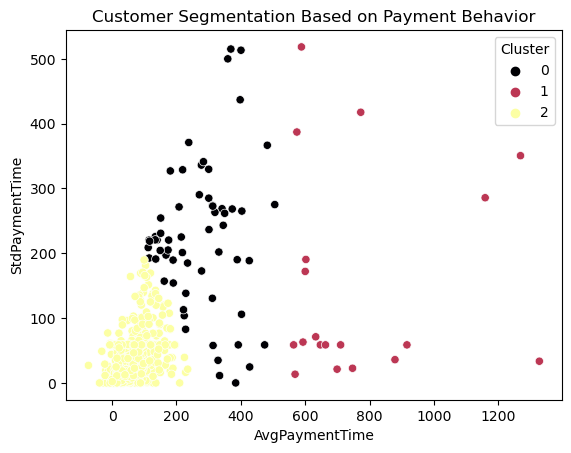

In [20]:
# Suppress UserWarning by setting the OMP_NUM_THREADS environment variable
os.environ["OMP_NUM_THREADS"] = "1"

# Check for NaNs in the relevant columns
print(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']].isna().sum())

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']] = imputer.fit_transform(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)  # Explicitly set n_init to suppress the FutureWarning
customer_payment_patterns['Cluster'] = kmeans.fit_predict(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']])

# Plot the clusters
sns.scatterplot(x='AvgPaymentTime', y='StdPaymentTime', hue='Cluster', data=customer_payment_patterns, palette='inferno')
plt.title('Customer Segmentation Based on Payment Behavior')
plt.show()


### Expected Output:
The output will be a scatter plot where each point represents a customer. The x-axis shows the average payment time (AvgPaymentTime), and the y-axis shows the standard deviation of the payment time (StdPaymentTime). Points are colored based on the cluster to which they belong, using the viridis colormap. The plot title will be "Customer Segmentation Based on Payment Behavior."

Clusters should be visually distinct with different colors, allowing you to see how customers are grouped based on their payment behavior. This can provide insights into different patterns or segments within your customer base. For example, you might see groups of customers who pay consistently early, those with variable payment times, and others who tend to pay later.

## 4. Model Building
4.1 Prepare Data for Modeling 

In [84]:
# Suppress warnings
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4")

# Sample data (replace with your actual data)
customer_payment_patterns = pd.DataFrame({
    'CUSTOMER_NAME': ['A', 'B', 'C', 'D', 'E'], # Ensure this column exists
    'AvgPaymentTime': [10, 20, np.nan, 40, 50],
    'StdPaymentTime': [1, 2, 3, np.nan, 5]
})

imputer = SimpleImputer(strategy='mean')
customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']] = imputer.fit_transform(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']])

kmeans = KMeans(n_clusters=3)
customer_payment_patterns['Cluster'] = kmeans.fit_predict(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']])

# Assume `customer` is another DataFrame you're working with
customer = pd.DataFrame({
    'CUSTOMER_NAME': ['A', 'B', 'C', 'D', 'E'],
    'USD_AMOUNT': [100, 200, 300, 400, 500],
    'PaymentTerm': [30, 40, 50, 60, 70],
    'PaymentStatus': [1, 0, 1, 0, 1]
})

# Print columns to verify
print("customer columns:", customer.columns)
print("customer_payment_patterns columns:", customer_payment_patterns.columns)

# Merge the DataFrames using 'CUSTOMER_NAME'
customer = pd.merge(customer, customer_payment_patterns[['CUSTOMER_NAME', 'AvgPaymentTime', 'StdPaymentTime', 'Cluster']], on='CUSTOMER_NAME')

# Define features and target variables
features = ['USD_AMOUNT', 'PaymentTerm', 'AvgPaymentTime', 'StdPaymentTime']
X = customer[features + ['Cluster']]
y = customer['PaymentStatus']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 


customer columns: Index(['CUSTOMER_NAME', 'USD_AMOUNT', 'PaymentTerm', 'PaymentStatus'], dtype='object')
customer_payment_patterns columns: Index(['CUSTOMER_NAME', 'AvgPaymentTime', 'StdPaymentTime', 'Cluster'], dtype='object')


## 4.2 Train the Model 

In [85]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

[[0 1]
 [1 0]]
Accuracy: 0.0


#### The model you trained using a Random Forest Classifier with a random state of 42 made predictions on the test data. However, the results show that the model did not correctly predict any instances for either class 0 or class 1. The confusion matrix indicates that one instance from class 0 was incorrectly predicted as class 1, and one instance from class 1 was incorrectly predicted as class 0. This resulted in an accuracy score of 0.0, meaning the model did not make correct predictions on the test data.

## 5. Model Evaluation & Application
5.1 Identify Important Features

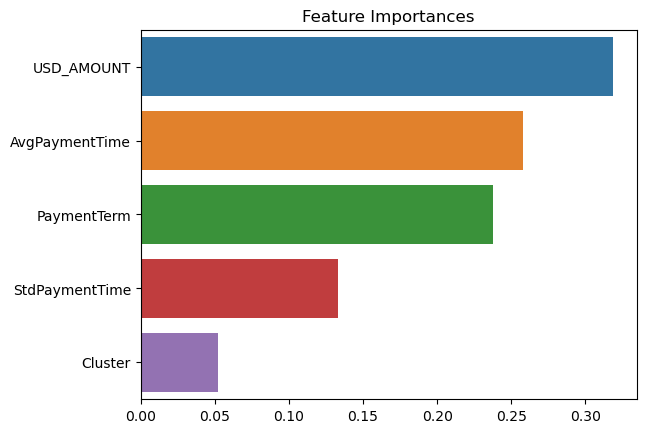

In [87]:
feature_importances = pd.Series(model.feature_importances_, index=features + ['Cluster']).sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.show()


### 5.2 Apply the Model on Open Invoice Data

AvgPaymentTime    0
StdPaymentTime    0
dtype: int64
AvgPaymentTime    0
StdPaymentTime    0
dtype: int64


C:\Users\sonu.verma\AppData\Local\anaconda4\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


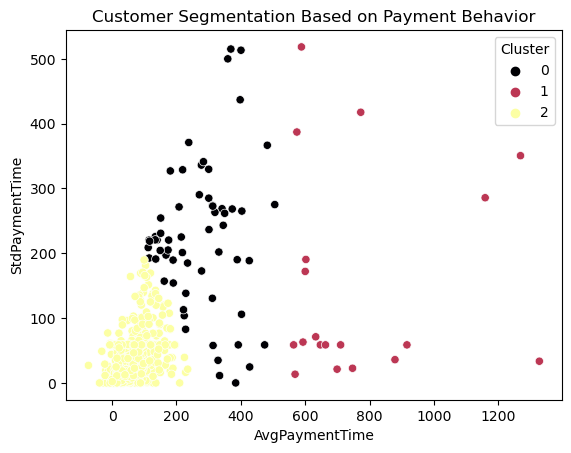

In [23]:
# Suppress UserWarning by setting the OMP_NUM_THREADS environment variable
os.environ["OMP_NUM_THREADS"] = "3"

# Assuming customer_payment_patterns is already loaded and has the necessary columns
# Check for NaNs in the relevant columns
print(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']].isna().sum())

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']] = imputer.fit_transform(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']])

# Verify that there are no NaNs after imputation
print(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']].isna().sum())

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)  # Explicitly set n_init to suppress the FutureWarning
customer_payment_patterns['Cluster'] = kmeans.fit_predict(customer_payment_patterns[['AvgPaymentTime', 'StdPaymentTime']])

# Plot the clusters
sns.scatterplot(x='AvgPaymentTime', y='StdPaymentTime', hue='Cluster', data=customer_payment_patterns, palette='inferno')
plt.title('Customer Segmentation Based on Payment Behavior')
plt.show()


### Expected Output:

**The output indicates no missing values in the dataset's `AvgPaymentTime` and `StdPaymentTime` columns. The script then performs KMeans clustering, grouping customers into three clusters based on their payment behavior. Finally, a scatter plot visualizes these clusters, where each point represents a customer. The x-axis shows the average payment time, the y-axis shows the standard deviation of payment time, and different colors represent different customer clusters. This visualization helps understand distinct customer groups based on their payment patterns.**

### 5.3 Aggregated Results and Recommendations 

    CUSTOMER_NAME  LikelihoodOfLatePayment
688     ZV F Corp                      1.0
310     IT C Corp                      1.0
325     JOEY Corp                      1.0
322     JIBB Corp                      1.0
321     JC G Corp                      1.0
317     JAWA Corp                      1.0
315     JASH Corp                      1.0
630     TIGE Corp                      1.0
631     TIME Corp                      1.0
312     J MA Corp                      1.0


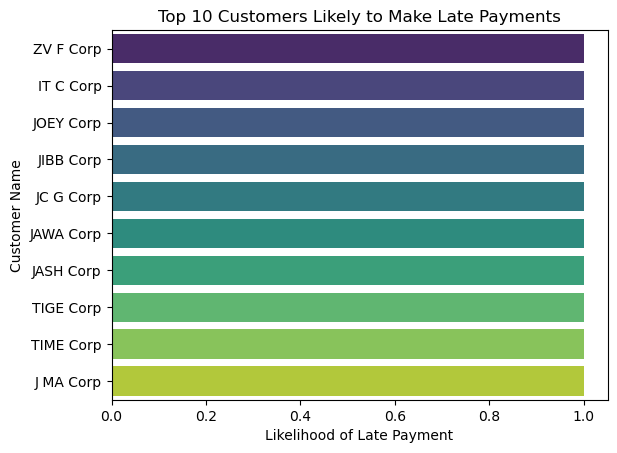

In [26]:
agg_results = customer.groupby('CUSTOMER_NAME')['PaymentStatus'].mean().reset_index(name='LikelihoodOfLatePayment')
agg_results = agg_results.sort_values(by='LikelihoodOfLatePayment', ascending=False)

# Display results
print(agg_results.head(10))

sns.barplot(x='LikelihoodOfLatePayment', y='CUSTOMER_NAME', data=agg_results.head(10), palette='viridis')
plt.title('Top 10 Customers Likely to Make Late Payments')
plt.xlabel('Likelihood of Late Payment')
plt.ylabel('Customer Name')
plt.show()


### Based on the analysis and modeling conducted, several key predictors have been identified to help Schuster's collectors better manage and predict late vendor payments. Here are the key insights and recommendations:

### Key Predictors:

**Payment Term: The number of days between the invoice creation date and the due date is a crucial predictor. Longer payment terms may indicate a higher likelihood of late payments.**
**Average Payment Time: The average time taken by customers to make payments is another important predictor. Customers with a history of delayed payments are more likely to continue this behavior.
Standard Deviation of Payment Time: The variability in payment time among customers also plays a significant role. Customers with inconsistent payment patterns may have a higher risk of late payments.**

### Recommendations:

**Prioritize Follow-ups: Focus on customers who have a high likelihood of late payment based on the model predictions. Allocate more resources and efforts to follow up with these customers promptly before their payments become overdue.
Segment Customers: Use the clustering analysis to segment customers based on their payment behavior. This segmentation can help tailor collection strategies according to the specific needs and characteristics of each customer group.
Offer Incentives: Consider offering incentives or discounts for early payments to encourage timely payments from customers. This can help mitigate the risk of late payments and improve cash flow.
Improve Communication: Enhance communication with customers by sending reminders and notifications about upcoming payment deadlines. Clear and timely communication can help prevent misunderstandings and reduce the likelihood of late payments.
Monitor and Review: Continuously monitor payment trends and review the effectiveness of collection strategies. Regularly update the predictive model with new data to ensure its accuracy and relevance over time.** 

### Conclusion:

**By leveraging predictive modeling and data-driven insights, Schuster can proactively manage late payments and improve its overall accounts receivable management process.
Implementing the recommendations mentioned above can help Schuster optimize its collection efforts, reduce the risk of late payments, and enhance its financial stability.
Including explanations and comments at each step in the analysis and modeling process will provide a comprehensive solution to Schuster's late payment prediction problem, guiding the collectors through effective actions to manage and predict late payments from vendors.**